In [10]:
# 라이브러리 불러올때 matplot 관련 오류뜨면 실행하세요
# 커널 : 학원 수업 기준 base 커널 사용했습니다

# pip install torch torchvision matplotlib

In [2]:
# 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms, models


In [3]:
# 하드웨어 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# 데이터 전처리
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # 크기를 조정
    transforms.CenterCrop((64, 64)),  # 중심을 기준으로 크롭 (추천: 64x64)
    transforms.ToTensor(),           # Tensor로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])


In [5]:
# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)


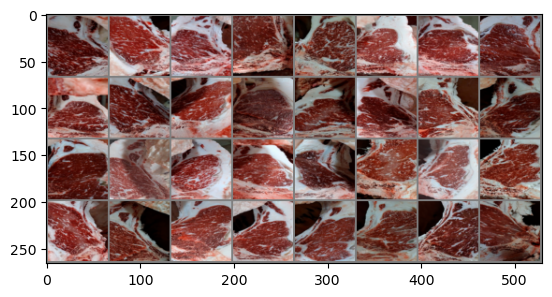

Labels: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [6]:
import torchvision
# 이미지 시각화 함수
def imshow(img):
    # 정규화를 다시 되돌림
    img = img / 2 + 0.5  # mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] 복원
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))  # (C, H, W) -> (H, W, C)
    plt.show()

# 데이터 확인
data_iter = iter(valid_loader)
images, labels = next(data_iter)

# 이미지를 격자로 배치하고 출력
imshow(torchvision.utils.make_grid(images))
print('Labels:', labels)

# 데이터 갯수 확인

In [7]:
print(f"Train dataset size: {len(train_data)}")
print(f"Validation dataset size: {len(valid_data)}")


Train dataset size: 1500
Validation dataset size: 500


# 데이터 크기 확인

In [8]:
images, labels = next(iter(train_loader))
print(f"Sample batch shape: {images.shape}, Labels: {labels}")


Sample batch shape: torch.Size([32, 3, 64, 64]), Labels: tensor([4, 0, 3, 1, 3, 0, 3, 2, 0, 2, 3, 0, 2, 0, 2, 1, 0, 1, 3, 3, 1, 4, 2, 1,
        1, 2, 0, 1, 3, 1, 2, 4])


# 모델 저장 코드

In [11]:
def save_model_checkpoint(model, optimizer, epoch, train_loss_list, valid_loss_list, train_acc_list, valid_acc_list, filepath="cow_model_checkpoint.pth"):
    checkpoint = {
        'model_state_dict': model.state_dict(),  # 모델 파라미터 저장
        'optimizer_state_dict': optimizer.state_dict(),  # 옵티마이저 파라미터 저장
        'epoch': epoch,  # 현재 에포크 저장
        'train_loss_list': train_loss_list,  # 학습 손실 저장
        'valid_loss_list': valid_loss_list,  # 검증 손실 저장
        'train_acc_list': train_acc_list,  # 학습 정확도 저장
        'valid_acc_list': valid_acc_list  # 검증 정확도 저장
    }
    torch.save(checkpoint, filepath)
    print(f"Model checkpoint saved at {filepath}", flush=True)


# 이미지 예측하기
- 사용할 모델 수정해야함
- 예측에 사용할 이미지 경로 수정해야함
- 주석 (경로에 맞게 수정) 이라고 되어있는 부분 확인 필수

In [9]:
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image

# 하드웨어 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 데이터 전처리 정의
transform_test = transforms.Compose([
    transforms.Resize((150, 150)),                # 크기 조정
    transforms.CenterCrop((128, 128)),            # 중심 크롭
    transforms.ToTensor(),                        # 텐서로 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# 모델 클래스 정의 (학습에 사용한 모델과 동일해야 함)
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=False)  # 사전 학습 해제 (로드 시 False)
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.6),  # Dropout 비율 증가
            nn.Linear(256, num_classes)  # 출력 크기 변경
        )

    def forward(self, x):
        return self.base_model(x)

# 모델 로드
num_classes = len(train_data.classes)  # 학습 데이터에서 클래스 수 가져오기
model = FineTunedResNet(num_classes=num_classes).to(device)
checkpoint_path = "../model_checkpoint_80 - 복사본.pth"                      # 테스트에 사용할 모델 경로(경로에 맞게 수정)
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()  # 평가 모드로 설정

# 이미지 로드 및 전처리 및 확률 출력 함수
def test_model_with_probabilities(model, image_path, class_names):
    # 이미지 로드 및 전처리
    image = Image.open(image_path).convert("RGB")  # RGB 형식으로 변환
    processed_image = transform_test(image).unsqueeze(0).to(device)  # 배치 차원 추가

    # 추론
    with torch.no_grad():
        outputs = model(processed_image)
        probabilities = F.softmax(outputs, dim=1)  # 확률로 변환

    # 확률과 클래스 출력
    probabilities = probabilities.cpu().squeeze().numpy()  # numpy 변환
    for idx, prob in enumerate(probabilities):
        print(f"Class: {class_names[idx]}, Probability: {prob:.4f}")

    # 가장 높은 확률의 클래스 예측
    predicted_idx = probabilities.argmax()
    predicted_class = class_names[predicted_idx]
    print(f"\nPredicted Class: {predicted_class} with Probability: {probabilities[predicted_idx]:.4f}")
    return probabilities, predicted_class

# 테스트 실행
image_path = "../test_1.jpg"                                                 # 테스트 이미지 경로(경로에 맞게 수정)
class_names = train_data.classes  # 클래스 이름 (폴더 이름)
probabilities, predicted_class = test_model_with_probabilities(model, image_path, class_names)

# 최종 결과 출력
print(f"\nFinal Predicted Class: {predicted_class}")


c:\Users\COM\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\COM\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\COM\AppData\Local\Temp\ipykernel_3256\836254310.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `T

Class: 1, Probability: 0.9546
Class: 1+, Probability: 0.0306
Class: 1++, Probability: 0.0052
Class: 2, Probability: 0.0095
Class: 3, Probability: 0.0000

Predicted Class: 1 with Probability: 0.9546

Final Predicted Class: 1


# 머신러닝에 사용한 코드
- 전처리 사항 확인 바랍니다
- 중요한 부분은 주석달아놨습니다

C:\Users\COM\AppData\Local\Temp\ipykernel_12724\184564177.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(saved_checkpoint, map_location=device)

Resuming training from epoch 76...
Epoch [77/100]
Train Loss: 0.4866, Train Accuracy: 81.93%
Valid Loss: 0.7713, Valid Accuracy: 69.40%
Epoch [78/100]
Train Loss: 0.4575, Train Accuracy: 82.73%
Valid Loss: 0.7788, Valid Accuracy: 69.80%
Epoch [79/100]
Train Loss: 0.4607, Train Accuracy: 83.27%
Valid Loss: 0.7679, Valid Accuracy: 68.80%
Epoch [80/100]
Train Loss: 0.4551, Train Accuracy: 85.07%
Valid Loss: 0.7475, Valid Accuracy: 71.60%
Epoch [81/100]
Train Loss: 0.3913, Train Accuracy: 85.87%
Valid Loss: 0.7615, Valid Accuracy: 71.00%
Epoch [82/100]
Train Loss: 0.3998, Train Accuracy: 85.13%
Valid Loss: 0.7647, Valid Accuracy: 69.20%
Epoch [83/100]
Train Loss: 0.4138, Train Accuracy: 85.00%
Valid Loss: 0.7653, Valid Accuracy: 71.20%
Epoch [84/100]
Train Loss: 0.3797, Train Accuracy: 86.87%
Valid Loss: 0.7702, Valid Accuracy: 70.60%
Epoch [85/100]
Train Loss: 0.3821, Train Accuracy: 85.33%
Valid Loss: 0.7658, Valid Accuracy: 70.60%
Epoch [86/100]
Train Loss: 0.3697, Train Accuracy: 87.60

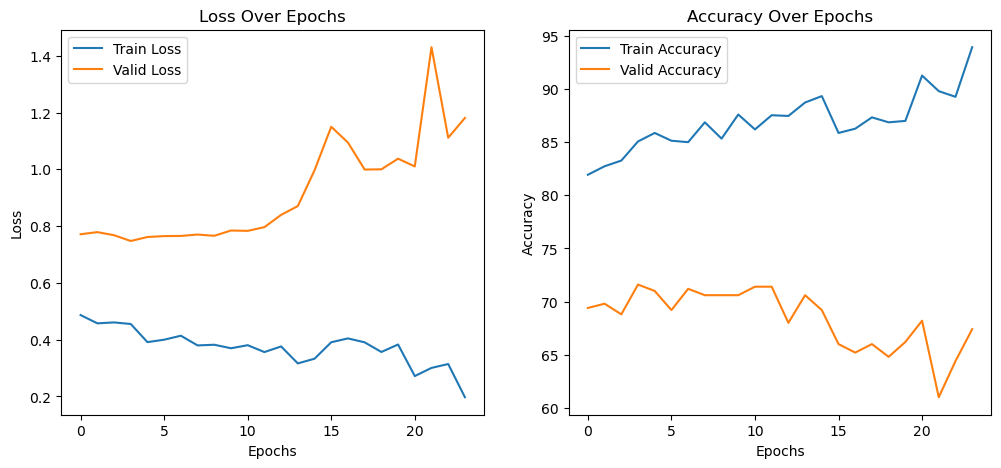

In [11]:
# 필요한 라이브러리 불러오기
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
# 하드웨어 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 강조 색상 효과 함수 정의
def emphasize_colors(img):
    # PIL 이미지를 HSV로 변환
    img = img.convert("HSV")  # Hue-Saturation-Value 공간으로 변환
    np_img = np.array(img)

    # Hue 범위: 노란색 (30~60), 빨간색 (0~30 또는 330~360)
    mask_yellow = (np_img[:, :, 0] > 25) & (np_img[:, :, 0] < 65)
    mask_red = (np_img[:, :, 0] < 25) | (np_img[:, :, 0] > 330)

    # Saturation(채도)와 Value(밝기) 강화
    np_img[:, :, 1][mask_yellow | mask_red] = np.clip(np_img[:, :, 1][mask_yellow | mask_red] * 1.2, 0, 255)  # 채도 강화
    np_img[:, :, 2][mask_yellow | mask_red] = np.clip(np_img[:, :, 2][mask_yellow | mask_red] * 1.1, 0, 255)  # 밝기 강화

    # 다시 PIL 이미지로 변환
    return Image.fromarray(np_img, mode="HSV").convert("RGB")

# 기존 transform_train에 색 강조 효과 추가
transform_train = transforms.Compose([
    transforms.Resize((150, 150)),                # 크기를 먼저 늘림
    transforms.CenterCrop((128, 128)),            # 중심 크롭
    transforms.RandomRotation(20),               # 약간의 랜덤 회전
    transforms.ColorJitter(brightness=0.3,       # 밝기 조정
                           contrast=0.6,         # 대비 강화
                           saturation=0.5,       # 채도 강화
                           hue=0.05),            # 색조 변화 범위
    transforms.Lambda(emphasize_colors),         # 강조 색상 효과 추가
    transforms.ToTensor(),                        # Tensor 변환
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # 정규화
])

# 데이터 로드
train_data = datasets.ImageFolder(root="./data/train", transform=transform_train)
valid_data = datasets.ImageFolder(root="./data/valid", transform=transform_valid)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=32, shuffle=False)

# 사전 학습된 모델 (ResNet-18) 로드 및 수정
class FineTunedResNet(nn.Module):
    def __init__(self, num_classes):
        super(FineTunedResNet, self).__init__()
        self.base_model = models.resnet18(pretrained=True)  # ResNet-18 로드
        self.base_model.fc = nn.Sequential(
            nn.Linear(self.base_model.fc.in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),  # Dropout 추가
            nn.Linear(256, num_classes)  # 출력 크기 변경
        )

    def forward(self, x):
        return self.base_model(x)

# 저장된 모델 로드
model = FineTunedResNet(num_classes=len(train_data.classes)).to(device)
saved_checkpoint = "./model_checkpoint_76.pth"
checkpoint = torch.load(saved_checkpoint, map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])

# 손실 함수 및 옵티마이저 정의
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00005)  # 학습률 감소
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

# 새로운 학습률 스케줄러 설정
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=0.00001)  # 학습률 점진적 감소

# 총 목표 에포크를 설정
total_epochs = 100      # 70 epoch 부터 시작. 100까지 진행

# 이전 에포크 값 가져오기
start_epoch = checkpoint['epoch'] + 1
print(f"Resuming training from epoch {start_epoch}...")

# 학습 및 검증 함수 정의
def train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, start_epoch, epochs=total_epochs):
    train_loss_list = []
    valid_loss_list = []
    train_acc_list = []
    valid_acc_list = []

    for epoch in range(start_epoch, epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss_list.append(train_loss / len(train_loader))
        train_acc_list.append(100. * correct / total)

        # Validation
        model.eval()
        valid_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in valid_loader:
                images, labels = images.to(device), labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)

                valid_loss += loss.item()
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        valid_loss_list.append(valid_loss / len(valid_loader))
        valid_acc_list.append(100. * correct / total)

        print(f"Epoch [{epoch+1}/{epochs}]\n"
              f"Train Loss: {train_loss_list[-1]:.4f}, Train Accuracy: {train_acc_list[-1]:.2f}%\n"
              f"Valid Loss: {valid_loss_list[-1]:.4f}, Valid Accuracy: {valid_acc_list[-1]:.2f}%",
              flush=True)

        # 학습률 스케줄러 업데이트
        scheduler.step()

        # 모델 저장
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss_list,
            'valid_loss': valid_loss_list,
            'train_acc': train_acc_list,
            'valid_acc': valid_acc_list
        }, f"model_checkpoint_{epoch+1}.pth")

    return train_loss_list, valid_loss_list, train_acc_list, valid_acc_list

# 학습 실행
train_loss, valid_loss, train_acc, valid_acc = train_model(model, train_loader, valid_loader, criterion, optimizer, scheduler, start_epoch, epochs=total_epochs)

# 학습 결과 시각화
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label='Train Loss')
plt.plot(valid_loss, label='Valid Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_acc, label='Train Accuracy')
plt.plot(valid_acc, label='Valid Accuracy')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()
